# heom

## Introduction
critically damped bath + spin boson phase transition

## Setup

In [2]:
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt

from qutip import *


from qutip.solver.heom import (
    BosonicBath,
    DrudeLorentzBath,
    DrudeLorentzPadeBath,
    HEOMSolver,
    HSolverDL,
    CorrelationFitter
)

from scipy.integrate import quad
from scipy.optimize import curve_fit

%matplotlib inline

In [3]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

In [4]:
def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

In [5]:
def plot_result_expectations(plots, axes=None,factor=1):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of: (solver_result, measurement_operation,
        color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(np.array(result.times)*factor, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [6]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [7]:

def integral(function,*args,**kwargs):
    if 'x_i' not in kwargs:
          raise Exception('Missing x_i, {} instead'.format(kwargs.keys()))
    if 'x_f' not in kwargs:
          raise Exception('Missing x_f, {} instead'.format(kwargs.keys()))
    x_i = kwargs['x_i']
    x_f = kwargs['x_f']
    limit = kwargs['limit']
    def function_real(x,*args):
        return np.real(function(x,*args))
    def function_imag(x,*args):
        return np.imag(function(x,*args))
        
    

    return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]


In [8]:
#some utility functions from SUMO

def coth2(beta,x):
    if x == 0:
        raise Exception('argument should not be zero')
    if beta == 'inf':
        return sg(np.real(x))
    return (np.exp(beta*x) + np.exp(-beta*x)) / (np.exp(beta*x) - np.exp(-beta*x))


def sg(t):
    if t > 0:
        return 1
    return -1
def theta(t):
    if t < 0:
        return 0
    return 1

def compute_correlations(J,beta,W_i,W_f,integration_limit,t_corr_list):
    def to_integrate_symmetric(w,t,J,beta):
        return 1 / (np.pi) * J(w) * coth2(beta,w/2.) * np.cos(w * t)
    def to_integrate_antisymmetric(w,t,J):
        return - 1 / (np.pi) * 1j * J(w) * np.sin(w * t)
    def compute_symmetric(J,beta,W_i,W_f,integration_limit,t_corr_list):
        print('Computing symmetric correlations ({length})'.format(length="t_corr_list"))
        res = []
        for t_index in np.arange(len(t_corr_list)):
            t = t_corr_list[t_index]
            res.append(integral(to_integrate_symmetric,t,J,beta,x_i=W_i,x_f=W_f,limit=integration_limit) )
        return res
    def compute_antisymmetric(J,W_i,W_f,integration_limit,t_corr_list):
        print('Computing antisymmetric correlations ({length})'.format(length="t_corr_list"))
        res = []
        for t_index in np.arange(len(t_corr_list)):
            t = t_corr_list[t_index]
            res.append(integral(to_integrate_antisymmetric,t,J,x_i=W_i,x_f=W_f,limit=integration_limit) )
        return res
    C_s = compute_symmetric(J,beta,W_i,W_f,integration_limit,t_corr_list)
    C_as = compute_antisymmetric(J,W_i,W_f,integration_limit,t_corr_list)
    return C_s, C_as

In [29]:
# Defining the system Hamiltonian
# Energy of the 2-level system.

eps = 0.1   #small system energy

Hsys =  0.5 * eps * sigmax() 


### ALPHA
alpha = 1.2
#alpha = 0.75

#BATH CUT OFF
wc = 10

t_corr_list = np.linspace(0,25,1000)

beta = np.inf
beta = 'inf'

W_i = 0
W_f = np.inf
integration_limit =  5000

def J(w):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2

#C_s,C_as = compute_correlations(J,beta,W_i,W_f,integration_limit,t_corr_list)

Fitting using Correlation Fitter

In [30]:
# Q = sigmaz()  # coupling operator
# t2=np.linspace(0,50,1000)
# C_s,C_as = compute_correlations(J,beta,W_i,W_f,integration_limit,t2)
# C = [C_s[kk]+C_as[kk] for kk,t in enumerate(t2)]
# fc=CorrelationFitter(Q,0,t2,C)


In [31]:
# bath,fitinfo=fc.get_fit(Ni=1,Nr=4)

In [32]:
# print(fitinfo["summary"])

In [33]:
# plt.plot(t2,np.real(C))
# plt.plot(t2,np.real(bath.correlation_function_approx(t2)),'-.')
# plt.xlim(0,50)

In [34]:
# plt.plot(t2,np.imag(C))
# plt.plot(t2,np.imag(bath.correlation_function_approx(t2)),'-.')

### Solving for the dynamics as a function of time:

Having created the lists which specify the bath correlation functions, we create a `BosonicBath` from them and pass the bath to the `HEOMSolver` class.

The solver constructs the "right hand side" (RHS) determinining how the system and auxiliary density operators evolve in time. This can then be used to solve for dynamics or steady-state.

Below we create the bath and solver and then solve for the dynamics by calling `.run(rho0, tlist)`.

In [35]:
# options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# # Number of levels of the hierarchy to retain:
# NC = 5  #this is an importance covnergence parameter
# Ttot = 300
# # Times to solve for:
# tlist = np.linspace(0, Ttot, 1000)
# rho0 = basis(2, 0) * basis(2, 0).dag()
# with timer("RHS construction time"):
#     HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
# with timer("ODE solver time"):
#     resultMatsnc5 = HEOMMats.run(rho0, tlist)

In [36]:

# #this one is a bit slow.... not sure how much further i can push this
# NC = 8  #this is an importance covnergence parameter
# with timer("RHS construction time"):
#     HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
# with timer("ODE solver time"):
#     resultMatsnc8 = HEOMMats.run(rho0, tlist)
    

In [37]:
#alpha = 0.75 @ 4 R, 2 I
# fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


# plot_result_expectations([    
#     (resultMatsnc5, sigmaz(), 'g', "heom $N_c=5$"),
#     (resultMatsnc8, sigmaz(), 'k', "heom $N_c=8$"),
# ], axes=axes)


# #axes.locator_params(axis='y', nbins=8)
# #axes.locator_params(axis='x', nbins=8)
# #axes.set_ylim(0.5,1.01)
# #axes.set_xlim(0,200)
# axes.legend(loc=0)

# fig.tight_layout()

In [38]:

# #this one is a bit slow.... not sure how much further i can push this
# NC = 11  #this is an importance covnergence parameter
# with timer("RHS construction time"):
#     HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
# with timer("ODE solver time"):
#     resultMatsnc11 = HEOMMats.run(rho0, tlist)

In [39]:
firstcase=qload("transition_1.2")

Example is Done, Now we take a look a weaker coupling to compare

In [40]:
alpha=0.01
def J2(w):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2


In [44]:
bath = BosonicBath(Q, [], [], [], [], T=0)
bath.spectral_density=J2

In [45]:
C=bath.correlation_function(t2)

In [47]:
Q = sigmaz()  # coupling operator
t2=np.linspace(0,50,1000)
C_s,C_as = compute_correlations(J2,beta,W_i,W_f,integration_limit,t2)
C2 = [C_s[kk]+C_as[kk] for kk,t in enumerate(t2)]
fc2=CorrelationFitter(Q,0,t2,C)

Computing symmetric correlations (t_corr_list)


/tmp/ipykernel_4554/94357179.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]
/tmp/ipykernel_4554/94357179.py:16: IntegrationWarning: The maximum number of subdivisions (5000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]


Computing antisymmetric correlations (t_corr_list)


In [ ]:
bath,fitinfo=fc2.get_fit(Ni=1,Nr=4)

In [ ]:
print(fitinfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 4 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 2.66e+00 |-1.62e+00 |1.34e-01                              | 1         |-2.89e+00 |-9.88e+00 |1.35e+00                              
 2         |-6.84e-02 |-3.50e+01 |1.91e+01                              |                                                                        
 3         |-2.74e+00 |-1.65e+00 |5.44e-06                              |A  normalized RM

(0.0, 50.0)

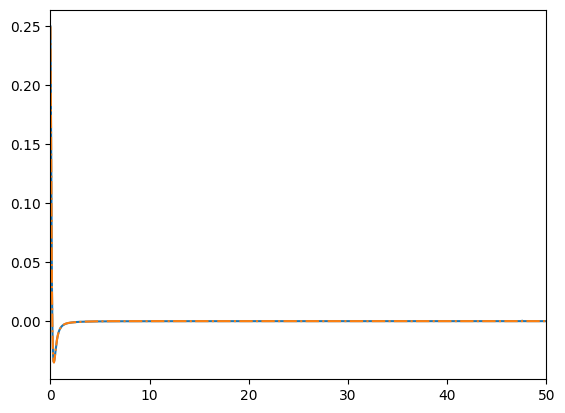

In [ ]:
plt.plot(t2,np.real(C))
plt.plot(t2,np.real(bath.correlation_function_approx(t2)),'-.')
plt.xlim(0,50)

In [ ]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 5  #this is an importance covnergence parameter
Ttot = 300
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc5_2 = HEOMMats.run(rho0, tlist)

/home/mcditoos/qutip_gsoc_app/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


RHS construction time: 0.1370222568511963
10.0%. Run time:  62.14s. Est. time left: 00:00:09:18
20.0%. Run time: 130.76s. Est. time left: 00:00:08:42
30.0%. Run time: 198.65s. Est. time left: 00:00:07:42
40.0%. Run time: 265.27s. Est. time left: 00:00:06:37
50.1%. Run time: 331.45s. Est. time left: 00:00:05:30
60.1%. Run time: 396.57s. Est. time left: 00:00:04:23
70.1%. Run time: 427.64s. Est. time left: 00:00:03:02
80.1%. Run time: 460.30s. Est. time left: 00:00:01:54
90.1%. Run time: 491.76s. Est. time left: 00:00:00:54
100.0%. Run time: 522.61s. Est. time left: 00:00:00:00
Total run time: 522.61s
ODE solver time: 522.6139006614685


In [ ]:

#this one is a bit slow.... not sure how much further i can push this
NC = 8  #this is an importance covnergence parameter
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc8_2 = HEOMMats.run(rho0, tlist)
    

RHS construction time: 1.664017677307129
10.0%. Run time: 829.70s. Est. time left: 00:02:04:19


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

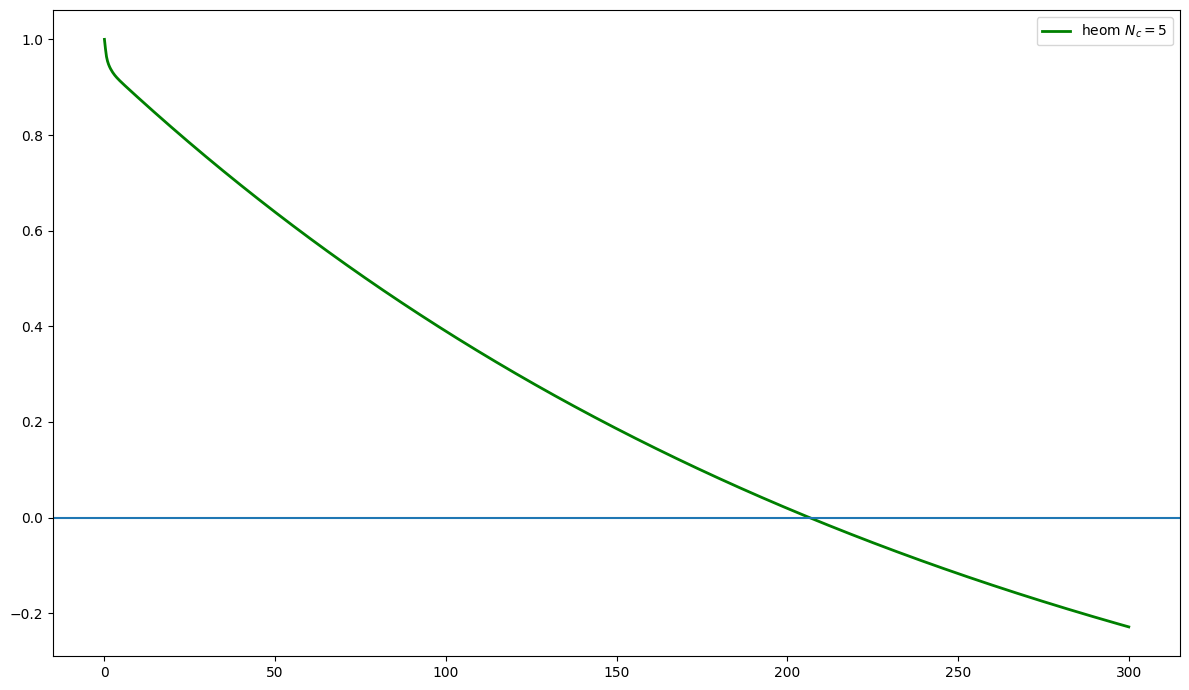

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    (resultMatsnc5_2, sigmaz(), 'g', "heom $N_c=5$"),
    #(resultMatsnc8_2, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes)

plot_result_expectations([    
    #(resultMatsnc5, sigmaz(), 'g', "heom $N_c=5$"),
    #(resultMatsnc8, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes)
#plt.xlim(0,1)
plt.axhline(y=0)
#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
#axes.set_ylim(0.5,1.01)
#axes.set_xlim(0,200)
axes.legend(loc=0)

fig.tight_layout()

In [ ]:
alpha=0.4
def J2(w):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2
Q = sigmaz()  # coupling operator
t2=np.linspace(0,50,1000)
C_s,C_as = compute_correlations(J2,beta,W_i,W_f,integration_limit,t2)
C = [C_s[kk]+C_as[kk] for kk,t in enumerate(t2)]
fc2=CorrelationFitter(Q,0,t2,C)

Computing symmetric correlations (t_corr_list)


/tmp/ipykernel_691270/94357179.py:16: IntegrationWarning: The maximum number of subdivisions (5000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]
/tmp/ipykernel_691270/94357179.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]


Computing antisymmetric correlations (t_corr_list)


In [ ]:
bath,fitinfo=fc2.get_fit(Ni=1,Nr=4)

In [ ]:
print(fitinfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 4 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-7.02e-01 |-1.73e-01 |9.70e-06                              | 1         |-1.16e+00 |-9.88e-01 |1.35e-01                              
 2         |-3.33e-02 |-3.62e+00 |2.99e-03                              |                                                                        
 3         | 6.69e-01 |-1.68e-01 |1.78e-02                              |A  normalized RM

In [ ]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 5  #this is an importance covnergence parameter
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc5_3 = HEOMMats.run(rho0, tlist)

RHS construction time: 0.15858030319213867
10.0%. Run time:   2.20s. Est. time left: 00:00:00:19
20.0%. Run time:   3.99s. Est. time left: 00:00:00:15
30.0%. Run time:   5.89s. Est. time left: 00:00:00:13
40.0%. Run time:   7.86s. Est. time left: 00:00:00:11
50.1%. Run time:   9.52s. Est. time left: 00:00:00:09
60.1%. Run time:  11.12s. Est. time left: 00:00:00:07
70.1%. Run time:  12.72s. Est. time left: 00:00:00:05
80.1%. Run time:  14.35s. Est. time left: 00:00:00:03
90.1%. Run time:  16.06s. Est. time left: 00:00:00:01
100.0%. Run time:  17.55s. Est. time left: 00:00:00:00
Total run time:  17.55s
ODE solver time: 17.552080631256104


In [ ]:
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
NC=8
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc8_3 = HEOMMats.run(rho0, tlist)

RHS construction time: 1.7926743030548096
10.0%. Run time:  56.73s. Est. time left: 00:00:08:30
20.0%. Run time: 121.39s. Est. time left: 00:00:08:04
30.0%. Run time: 188.89s. Est. time left: 00:00:07:20
40.0%. Run time: 259.26s. Est. time left: 00:00:06:28
50.1%. Run time: 359.54s. Est. time left: 00:00:05:58
60.1%. Run time: 421.87s. Est. time left: 00:00:04:40
70.1%. Run time: 477.18s. Est. time left: 00:00:03:23
80.1%. Run time: 537.40s. Est. time left: 00:00:02:13
90.1%. Run time: 598.09s. Est. time left: 00:00:01:05
100.0%. Run time: 656.98s. Est. time left: 00:00:00:00
Total run time: 656.98s
ODE solver time: 656.9820818901062


In [ ]:
# NC=11
# with timer("RHS construction time"):
#     HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
# with timer("ODE solver time"):
#     resultMatsnc11_3 = HEOMMats.run(rho0, tlist)

In [ ]:
qsave(resultMatsnc8_4,"trasition=0.6")

NameError: name 'resultMatsnc8_2' is not defined

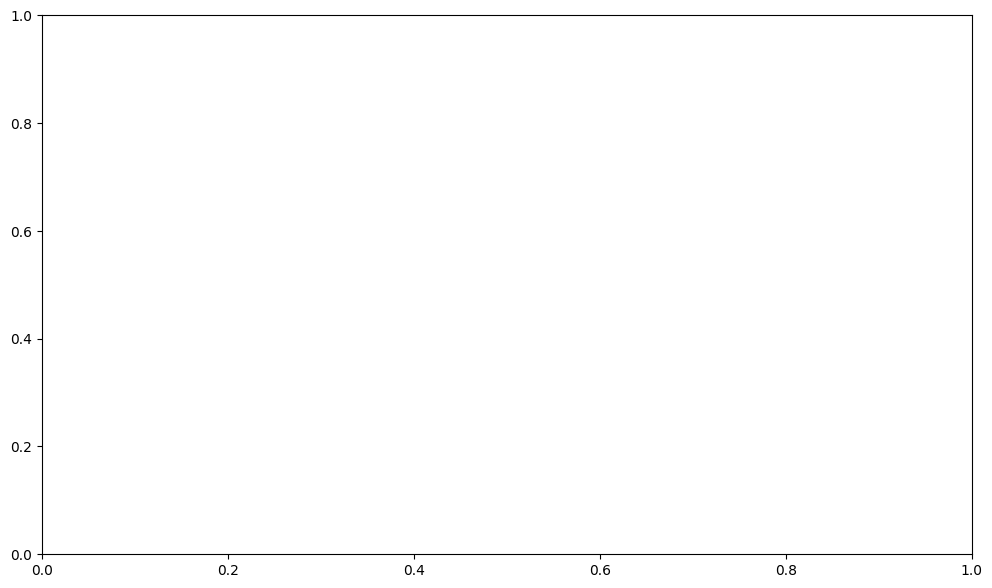

In [49]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    #(resultMatsnc5_2, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_2, sigmaz(), 'b', "$N_c=8, \\alpha=0.1$ "),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes,factor=eps)
plot_result_expectations([    
    #(resultMatsnc5_3, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_3, sigmaz(), 'g', "$N_c=8, \\alpha=0.4$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes,factor=eps)

plot_result_expectations([    
    #(resultMatsnc5_3, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_4, sigmaz(), 'purple', "$N_c=8, \\alpha=0.6$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes,factor=eps)
plot_result_expectations([    
    (firstcase, sigmaz(), 'r', "$N_c=5, \\alpha=1.2$"),
  #  (resultMatsnc8, sigmaz(), 'k', "heom $N_c=8$"),
 #   (resultMatsnc11, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes,factor=eps)
#plt.xlim(0,1)
plt.axhline(y=0)
#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
#axes.set_ylim(0.5,1.01)
#axes.set_xlim(0,200)
axes.legend(loc=0,fontsize=20)
axes.xaxis.set_tick_params(labelsize=20)
axes.yaxis.set_tick_params(labelsize=20)
plt.ylabel(r"$\langle \sigma_{z}(t) \rangle$",fontsize=20)
plt.xlabel(r"$\omega_{0}t$",fontsize=20)
fig.tight_layout()

In [ ]:
alpha=0.6
def J2(w):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2
Q = sigmaz()  # coupling operator
t2=np.linspace(0,50,1000)
C_s,C_as = compute_correlations(J2,beta,W_i,W_f,integration_limit,t2)
C = [C_s[kk]+C_as[kk] for kk,t in enumerate(t2)]
fc2=CorrelationFitter(Q,0,t2,C)

Computing symmetric correlations (t_corr_list)


/tmp/ipykernel_691270/94357179.py:16: IntegrationWarning: The maximum number of subdivisions (5000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]
/tmp/ipykernel_691270/94357179.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]


Computing antisymmetric correlations (t_corr_list)


In [ ]:
bath,fitinfo=fc2.get_fit(Ni=1,Nr=4)
print(fitinfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 4 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-3.00e+00 |-8.04e-01 |3.55e-04                              | 1         |-1.73e+00 |-9.88e-01 |1.35e-01                              
 2         | 1.82e+00 |-6.18e-01 |2.55e-01                              |                                                                        
 3         | 1.25e+00 |-1.06e+00 |4.81e-01                              |A  normalized RM

In [ ]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 8  #this is an importance covnergence parameter
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc5_4 = HEOMMats.run(rho0, tlist)

RHS construction time: 2.0276811122894287
10.0%. Run time: 107.18s. Est. time left: 00:00:16:03
20.0%. Run time: 212.97s. Est. time left: 00:00:14:10
30.0%. Run time: 352.92s. Est. time left: 00:00:13:42
40.0%. Run time: 465.15s. Est. time left: 00:00:11:36
50.1%. Run time: 584.84s. Est. time left: 00:00:09:43
60.1%. Run time: 716.19s. Est. time left: 00:00:07:56
70.1%. Run time: 831.29s. Est. time left: 00:00:05:55
80.1%. Run time: 938.04s. Est. time left: 00:00:03:53
90.1%. Run time: 1058.91s. Est. time left: 00:00:01:56
100.0%. Run time: 1165.41s. Est. time left: 00:00:00:00
Total run time: 1165.41s
ODE solver time: 1165.4199752807617


In [ ]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 8  #this is an importance covnergence parameter
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)
rho0 = basis(2, 0) * basis(2, 0).dag()
with timer("RHS construction time"):
    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)
with timer("ODE solver time"):
    resultMatsnc8_4 = HEOMMats.run(rho0, tlist)

RHS construction time: 1.9388961791992188
10.0%. Run time: 107.11s. Est. time left: 00:00:16:02
20.0%. Run time: 210.35s. Est. time left: 00:00:14:00
30.0%. Run time: 340.23s. Est. time left: 00:00:13:12
40.0%. Run time: 499.84s. Est. time left: 00:00:12:28
50.1%. Run time: 609.52s. Est. time left: 00:00:10:08
60.1%. Run time: 719.27s. Est. time left: 00:00:07:58
70.1%. Run time: 825.57s. Est. time left: 00:00:05:52
80.1%. Run time: 936.91s. Est. time left: 00:00:03:53
90.1%. Run time: 1048.60s. Est. time left: 00:00:01:55
100.0%. Run time: 1158.10s. Est. time left: 00:00:00:00
Total run time: 1158.10s
ODE solver time: 1158.0996530056


NameError: name 'resultMatsnc8_2' is not defined

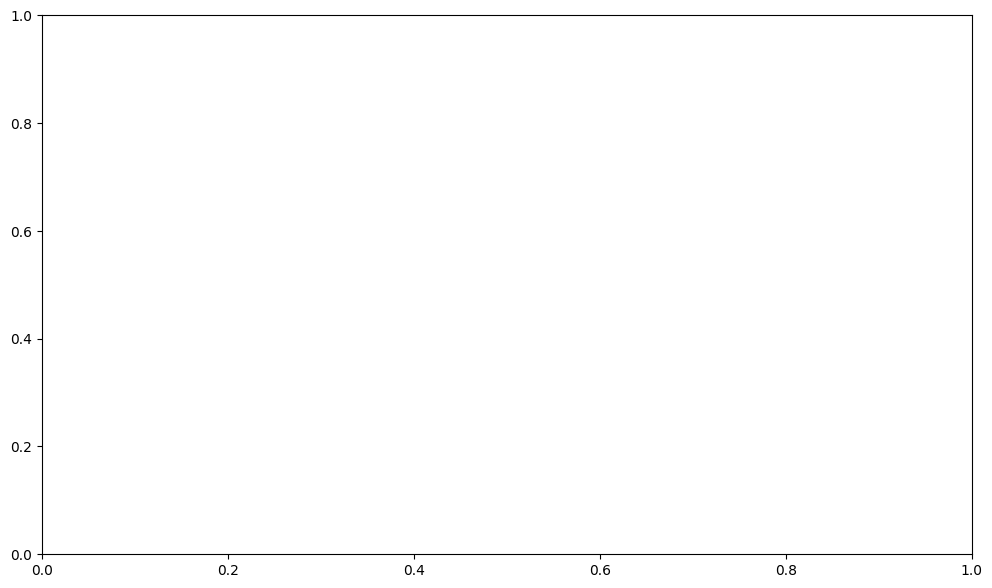

In [48]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    #(resultMatsnc5_2, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_2, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes,factor=eps)
plot_result_expectations([    
    (resultMatsnc5_3, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_3, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes)
plot_result_expectations([    
    #(resultMatsnc5_4, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_4, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes)
plot_result_expectations([    
    (resultMatsnc5_3, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc8_3, sigmaz(), 'k', "heom $N_c=8$"),
    #(resultMatsnc11_2, sigmaz(), 'r', "heom $N_c=11$"),
], axes=axes)
#plt.xlim(0,1)
plt.axhline(y=0)
#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
#axes.set_ylim(0.5,1.01)
#axes.set_xlim(0,200)
axes.legend(loc=0)

fig.tight_layout()